In [1]:
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D
import uuid


def dominance_diagram(logodds, stds, title, inverted=False, cut=False, filename=None):
    '''
    Plots a dominance diagram
    Parameters
    ----------
    :param logodds: A DataFrame of logodds: one row for study, one column for AI type
    :type logodds: DataFrame
    :param stds: A DataFrame of standard deviations: one row for study, one column for AI type
    :type stds: DataFrame
    :param title: The title of the graph
    :type title: string
    :param inverted: Check if colors are inverted (True) or not (False)
    :type inverted: bool
    :param cut: Check if graph is bounded between 0.1 and 10 (True) or not (False)
    :type cut: bool
    '''
    plt.figure(figsize=(10,10))

    palette = sns.color_palette('colorblind', n_colors=len(logodds.columns))

    if inverted:
        plt.axvspan(0.0, 1.0, alpha=0.2, color='blue')
        plt.axvspan(1.0, 1000.0, alpha=0.2, color='red')
    else:
        plt.axvspan(0.0, 1.0, alpha=0.2, color='red')
        plt.axvspan(1.0, 1000.0, alpha=0.2, color='blue')

    idx = 1
    for s in logodds.index:
        level = idx - 0.05*len(logodds.columns)/2
        step = 0.05

        idj = 0

        for v in logodds.columns:

            val = np.exp(logodds.loc[s,v])
            lower = np.exp(logodds.loc[s,v]) - np.exp(logodds.loc[s,v] - 1.96*np.sqrt(stds.loc[s,v]))
            upper = np.exp(logodds.loc[s,v] + 1.96*np.sqrt(stds.loc[s,v])) - np.exp(logodds.loc[s,v])
            

            if cut:
                if val > 10:
                    val = 10
                    upper = 10
                elif val < 0.1:
                    val = 0.1
                    lower = 0.1
                if upper > 10:
                    upper = 10
                if lower < 0.1:
                    lower = 0.1
            else:
                if val > 1000:
                    val = 1000
                    upper = 1000
                elif val < 0.001:
                    val = 0.001
                    lower = 0.001
                if upper > 1000:
                    upper = 1000
                if lower < 0.001:
                    lower = 0.001

            #print("%s - %s: %.2f [%.2f, %.2f] (logodds: %.2f, std: %.2f)" % (s, v, val, val-lower, val+upper, logodds.loc[s,v], stds.loc[s,v]))
            #print()

            plt.errorbar(val, level,
                         xerr=[[lower],
                               [upper]],
                         fmt="o",
                         color=palette[idj],
                         ecolor='k', zorder=2*idj)
            st = (" (%s)" % s) if s != "" else ""
            plt.scatter(val, level,
                         label=v + st + (" %.2f [%.2f,%.2f]" % (val, val-lower, val+upper)),
                         color=palette[idj],
                         edgecolors='k', zorder=2*idj+1)

            plt.ylim(0,5)

            plt.xscale("log")

            if cut:
                plt.xlim(0.1,10)
                plt.xticks([0.1, 0.2, 0.5, 1, 2, 5, 10], ["< -10", -5, -2, "No impact", 2, 5, "> 10"])
            else:
                plt.xlim(0.001,1000)
                plt.xticks([0.001,0.01,0.1, 1, 10, 100, 1000], [-1000, -100, -10, "No impact", 10, 100, 1000])

            level += step
            if level == 1.0 and len(logodds.columns)%2 == 0:
                level += 0.05
            idj += 1

        idx += 1

    plt.ylim(0, len(logodds.index)+1)
    plt.yticks(range(len(logodds.index) + 1), [""] + list(logodds.index) )
    plt.axvline(1, ls='--', c='k', lw=0.75)
    plt.xlabel(title)

    handles = []
    
    for s in logodds.index:
        i = 0
        for v in logodds.columns:
            val = np.exp(logodds.loc[s,v])
            lower = np.exp(logodds.loc[s,v]) - np.exp(logodds.loc[s,v] - 1.96*np.sqrt(stds.loc[s,v]))
            upper = np.exp(logodds.loc[s,v] + 1.96*np.sqrt(stds.loc[s,v])) - np.exp(logodds.loc[s,v])
            st = (" (%s)" % s) if s != "" else ""
            handles.append(Line2D([0], [0], marker='o', color=palette[i], label=v + st + (" %.2f [%.2f,%.2f]" % (val, val-lower, val+upper)),
                                  markeredgecolor='k'))
            i += 1

    plt.legend(handles=handles)
    #plt.savefig(title + ".png", dpi=500, bbox_inches="tight")
    path =  filename + "_" + title + ".png"
    plt.savefig(path, dpi=500, bbox_inches="tight")
    return path

def compute_reliance(data):
    '''
    Computes the reliance pattern table
    Parameters
    ----------
    :param data: A DataFrame of cases
    :type data: DataFrame
    '''
    colnames =  ["Count (" + str(v) + ")" for v in data["Type_AI"].unique()]
    patterns = None
    if ("AI" in data.columns):
        patterns = pd.DataFrame(np.zeros((9, 3 + len(colnames)), dtype=int), columns=["HD1","AI","FHD"] + list(colnames))
        lst = list(itertools.product([0, 1], repeat=3))
        for i in range(8):
            for j in range(3):
                patterns.iloc[i,j] = lst[i][j]
            for v in data["Type_AI"].unique():
                patterns.loc[i, "Count (" + str(v) + ")"] = data[((data["HD1"] == lst[i][0]) &
                                                             (data["AI"] == lst[i][1])  &
                                                             (data["FHD"] == lst[i][2]) &
                                                             (data["Type_AI"] == v))].shape[0]

        for v in data["Type_AI"].unique():  
            for j in range(3):
                patterns.iloc[8,j] = "*"      
            patterns.loc[8, "Count (" + str(v) + ")"] = data[data["Type_AI"] == v].shape[0]
    else:
        patterns = pd.DataFrame(np.zeros((5, 2 + len(colnames)), dtype=int), columns=["HD1", "FHD"] + list(colnames))
        lst = list(itertools.product([0, 1], repeat=2))
        for i in range(4):
            for j in range(2):
                patterns.iloc[i,j] = lst[i][j]
            for v in data["Type_AI"].unique():
                patterns.loc[i, "Count (" + str(v) + ")"] = data[((data["HD1"] == lst[i][0]) &
                                                             (data["FHD"] == lst[i][1]) &
                                                             (data["Type_AI"] == v))].shape[0]
        for v in data["Type_AI"].unique():  
            for j in range(2):
                patterns.iloc[4,j] = "*"      
            patterns.loc[4, "Count (" + str(v) + ")"] = data[data["Type_AI"] == v].shape[0]
    return patterns




def compute_dominance(data, cut=False, filename=None):
    '''
    Computes the frequentist dominance metrics
    Parameters
    ----------
    :param data: A DataFrame of cases
    :type data: DataFrame
    :param cut: Check if graph is bounded between 0.1 and 10 (True) or not (False)
    :type cut: bool
    '''
    cer = pd.DataFrame(np.zeros( ( len(data["Study"].unique()),
                                               len(data["Type_AI"].unique())
                                             )),
                                   index = data["Study"].unique(),
                                   columns = data["Type_AI"].unique())

    aier = pd.DataFrame(np.zeros( ( len(data["Study"].unique()),
                                               len(data["Type_AI"].unique())
                                             )),
                                   index = data["Study"].unique(),
                                   columns = data["Type_AI"].unique())

    logodds_general = pd.DataFrame(np.zeros( ( len(data["Study"].unique()),
                                               len(data["Type_AI"].unique())
                                             )),
                                   index = data["Study"].unique(),
                                   columns = data["Type_AI"].unique())

    stds_general = pd.DataFrame(np.zeros( ( len(data["Study"].unique()),
                                               len(data["Type_AI"].unique())
                                             )),
                                   index = data["Study"].unique(),
                                   columns = data["Type_AI"].unique())

    logodds_ab = pd.DataFrame(np.zeros( ( len(data["Study"].unique()),
                                               len(data["Type_AI"].unique())
                                             )),
                                   index = data["Study"].unique(),
                                   columns = data["Type_AI"].unique())

    stds_ab = pd.DataFrame(np.zeros( ( len(data["Study"].unique()),
                                               len(data["Type_AI"].unique())
                                             )),
                                   index = data["Study"].unique(),
                                   columns = data["Type_AI"].unique())

    logodds_av = pd.DataFrame(np.zeros( ( len(data["Study"].unique()),
                                               len(data["Type_AI"].unique())
                                             )),
                                   index = data["Study"].unique(),
                                   columns = data["Type_AI"].unique())

    stds_av = pd.DataFrame(np.zeros( ( len(data["Study"].unique()),
                                               len(data["Type_AI"].unique())
                                             )),
                                   index = data["Study"].unique(),
                                   columns = data["Type_AI"].unique())

    reliance = {}

    for s in data["Study"].unique():
        study = data[data["Study"] == s]

        reliance[s] = compute_reliance(study)

        for v in study["Type_AI"].unique():
            data_temp = study[study["Type_AI"] == v]

            aier.loc[s,v], cer.loc[s,v] = 0, 0

            if ("AI" not in data.columns):
                aier.loc[s,v] = data_temp[data_temp["FHD"] == 0].shape[0]/data_temp.shape[0]
                cer.loc[s,v] = data_temp[data_temp["HD1"] == 0].shape[0]/data_temp.shape[0]

            else:
                aier.loc[s,v] = data_temp[((data_temp["HD1"] == 0) & (data_temp["AI"] == 0) & (data_temp["FHD"] == 0)) |
                          ((data_temp["HD1"] == 0) & (data_temp["AI"] == 1) & (data_temp["FHD"] == 0)) |
                          ((data_temp["HD1"] == 1) & (data_temp["AI"] == 0) & (data_temp["FHD"] == 0)) |
                          ((data_temp["HD1"] == 1) & (data_temp["AI"] == 1) & (data_temp["FHD"] == 0))].shape[0]/data_temp.shape[0] + 0.5/data_temp.shape[0]

                cer.loc[s,v]  = data_temp[((data_temp["HD1"] == 0) & (data_temp["AI"] == 0) & (data_temp["FHD"] == 0)) |
                           ((data_temp["HD1"] == 0) & (data_temp["AI"] == 1) & (data_temp["FHD"] == 0)) |
                           ((data_temp["HD1"] == 0) & (data_temp["AI"] == 0) & (data_temp["FHD"] == 1)) |
                           ((data_temp["HD1"] == 0) & (data_temp["AI"] == 1) & (data_temp["FHD"] == 1))].shape[0]/data_temp.shape[0] + 0.5/data_temp.shape[0]


            logodds_general.loc[s,v] = np.log(cer.loc[s,v]/(1-cer.loc[s,v])*(1-aier.loc[s,v])/(aier.loc[s,v]))

            stds_general.loc[s,v] =  1/(aier.loc[s,v]*data_temp.shape[0])
            stds_general.loc[s,v] += 1/(cer.loc[s,v]*data_temp.shape[0])
            stds_general.loc[s,v] += 1/((1 - aier.loc[s,v])*data_temp.shape[0])
            stds_general.loc[s,v] += 1/((1 - cer.loc[s,v])*data_temp.shape[0])

            if ("AI" in data.columns):
                automation_bias = data_temp[(data_temp["HD1"] == 1) & (data_temp["AI"] == 0) & (data_temp["FHD"] == 0)].shape[0]/data_temp.shape[0] + 0.5/data_temp.shape[0]
                algorithmic_aversion = data_temp[(data_temp["HD1"] == 1) & (data_temp["AI"] == 0) & (data_temp["FHD"] == 1)].shape[0]/data_temp.shape[0] + 0.5/data_temp.shape[0]
                algorithmic_appreciation = data_temp[(data_temp["HD1"] == 0) & (data_temp["AI"] == 1) & (data_temp["FHD"] == 1)].shape[0]/data_temp.shape[0] + 0.5/data_temp.shape[0]
                conservatism_bias = data_temp[(data_temp["HD1"] == 0) & (data_temp["AI"] == 1) & (data_temp["FHD"] == 0)].shape[0]/data_temp.shape[0] + 0.5/data_temp.shape[0]

                #print("%s - %s: %.3f (automation), %.3f (aversion), %.3f (appreciation), %.3f (conservatism)" % (s, v, automation_bias, algorithmic_aversion, algorithmic_appreciation, conservatism_bias))

                logodds_ab.loc[s,v] = np.log(automation_bias/(1-automation_bias)*(1-algorithmic_aversion)/(algorithmic_aversion))
                stds_ab.loc[s,v] =  1/(automation_bias*data_temp.shape[0])
                stds_ab.loc[s,v] += 1/(algorithmic_aversion*data_temp.shape[0])
                stds_ab.loc[s,v] += 1/(data_temp.shape[0] - automation_bias*data_temp.shape[0])
                stds_ab.loc[s,v] += 1/(data_temp.shape[0] - algorithmic_aversion*data_temp.shape[0])

                logodds_av.loc[s,v] = np.log(conservatism_bias/(1 - conservatism_bias)*(1-algorithmic_appreciation)/(algorithmic_appreciation))
                stds_av.loc[s,v] =  1/(conservatism_bias*data_temp.shape[0])
                stds_av.loc[s,v] += 1/(algorithmic_appreciation*data_temp.shape[0])
                stds_av.loc[s,v] += 1/(data_temp.shape[0] - conservatism_bias*data_temp.shape[0])
                stds_av.loc[s,v] += 1/(data_temp.shape[0] - algorithmic_appreciation*data_temp.shape[0])

    diagrams = []
    diagrams.append(dominance_diagram(logodds_general, stds_general, "Tecnology Impact", cut=cut, filename=filename))
    if ("AI" in data.columns):
        av = data_temp[(data_temp["HD1"] == 1) & (data_temp["AI"] == 0) & (data_temp["FHD"] == 1)].shape[0]
        if av != 0:
            diagrams.append(dominance_diagram(logodds_ab, stds_ab, "Automation Bias", inverted=True, cut=cut, filename=filename))
        aa = data_temp[(data_temp["HD1"] == 0) & (data_temp["AI"] == 1) & (data_temp["FHD"] == 1)].shape[0]
        if aa != 0:
            diagrams.append(dominance_diagram(logodds_av, stds_av, "Conservatism Bias", inverted=True, cut=cut, filename=filename))
    return reliance, cer, aier, logodds_general, logodds_ab, logodds_av, stds_general, stds_ab, stds_av




def compute_factor(all_data, hd1, ai, fhd, complexity, group):
    '''
    Computes one factor for the causal dominance metrics
    Parameters
    ----------
    :param all_data: A DataFrame of cases
    :type all_data: DataFrame
    :param hd1: Value (correctness) of HD1
    :type hd1: int (Either 0 or 1)
    :param ai: Value (correctness) of AI
    :type ai: int (Either 0 or 1)
    :param fhd: Value (correctness) of FHD
    :type fhd: int (Either 0 or 1)
    :param complexity: Value of case complexity
    :type complexity: int or string
    :param group: A identifier denoting the AI type
    :type group: int or string
    '''
    data = all_data[all_data["Type_AI"] == group]
    condition_subset = data[(data["HD1"] == hd1) & (data["AI"] == ai) & (data["Complexity"] == complexity)]
    weight_subset = data[data["HD1"] == hd1]

    condition = condition_subset[condition_subset["FHD"] == fhd]
    weight = len(weight_subset[weight_subset["Complexity"] == complexity])/len(weight_subset)

    ratio = 0 if len(condition_subset) == 0 else len(condition)/len(condition_subset)

    return ratio, len(condition), len(condition_subset), weight


def compute_causal_dominance(data, cut=False, filename=None):
    '''
    Computes the causal dominance metrics
    Parameters
    ----------
    :param data: A DataFrame of cases
    :type data: DataFrame
    :param cut: Check if graph is bounded between 0.1 and 10 (True) or not (False)
    :type cut: bool
    '''
    logodds_ab = pd.DataFrame(np.zeros( ( len(data["Study"].unique()),
                                                   len(data["Type_AI"].unique())
                                                 )),
                                       index = data["Study"].unique(),
                                       columns = data["Type_AI"].unique())

    stds_ab = pd.DataFrame(np.zeros( ( len(data["Study"].unique()),
                                                   len(data["Type_AI"].unique())
                                                 )),
                                       index = data["Study"].unique(),
                                       columns = data["Type_AI"].unique())

    logodds_av = pd.DataFrame(np.zeros( ( len(data["Study"].unique()),
                                                   len(data["Type_AI"].unique())
                                                 )),
                                       index = data["Study"].unique(),
                                       columns = data["Type_AI"].unique())

    stds_av = pd.DataFrame(np.zeros( ( len(data["Study"].unique()),
                                                   len(data["Type_AI"].unique())
                                                 )),
                                       index = data["Study"].unique(),
                                       columns = data["Type_AI"].unique())

    for s in data["Study"].unique():
        study = data[data["Study"] == s]

        for v in study["Type_AI"].unique():
            res_ab = np.array([0,0], dtype=np.float64)
            counts_ab = np.array([0,0,0,0], dtype=np.float64)

            res_av = np.array([0,0], dtype=np.float64)
            counts_av = np.array([0,0,0,0], dtype=np.float64)

            for c in data["Complexity"].unique():
                val, num, denom, weight = compute_factor(study, 1, 0, 0, c, group=v)
                res_ab[0] += val*weight
                counts_ab[0] += num
                counts_ab[1] += denom

                val, num, denom, weight = compute_factor(study, 1, 0, 1, c, group=v)
                res_ab[1] += val*weight
                counts_ab[2] += num
                counts_ab[3] += denom

                val, num, denom, weight = compute_factor(study, 0, 1, 0, c, group=v)
                res_av[0] += val*weight
                counts_av[0] += num
                counts_av[1] += denom

                val, num, denom, weight = compute_factor(study, 0, 1, 1, c, group=v)
                res_av[1] += val*weight
                counts_av[2] += num
                counts_av[3] += denom

            logodds_ab.loc[s,v] = np.log(0.001 + res_ab[0]/(1-res_ab[0])*(1-res_ab[1])/res_ab[1])
            stds_ab.loc[s,v] = (np.sum(1/counts_ab))
            if stds_ab.loc[s,v] == np.inf:
                stds_ab.loc[s,v] = 0

            logodds_av.loc[s,v] = np.log(0.001 + res_av[0]/(1- res_av[0])*(1-res_av[1])/res_av[1])
            stds_av.loc[s,v] = (np.sum(1/counts_av))
            if stds_av.loc[s,v] == np.inf:
                stds_av.loc[s,v] = 0

    diagrams = []
    diagrams.append(dominance_diagram(logodds_ab, stds_ab, "Automation Bias (Causal)", inverted=True, cut=cut, filename=filename))
    diagrams.append(dominance_diagram(logodds_av, stds_av, "Conservatism Bias (Causal)", inverted=True, cut=cut, filename=filename))

    return logodds_ab, logodds_av, stds_ab, stds_av



def compute_chi_diagrams(file, cut=False, causal=True, filename=""):
    '''
    Compute the values of dominance metrics and then plots them.
    Parameters
    ----------
    :param filename: Name of the file containing the cases
    :type filename: string
    Check if graph is bounded between 0.1 and 10 (True) or not (False)
    :type cut: bool
    '''
    data = pd.read_csv(file)

    if ("HD1" not in data.columns):
        return "Mandatory field HD1 is missing!"

    if ("FHD" not in data.columns):
        return "Mandatory field FHD is missing!"

    if "Type_AI" not in data.columns:
        data["Type_AI"] = "Support"

    if "Study" not in data.columns:
        data["Study"] = ""

    if "Complexity" not in data.columns:
        data["Complexity"] = ""

    reliance, cer, aier, logodds_general, logodds_ab, logodds_av, stds_general, stds_ab, stds_av = compute_dominance(data, cut=cut, filename=filename)

    if causal:
        logodds_ab_causal, logodds_av_causal, stds_ab_causal, stds_av_causal = 0, 0, 0, 0
        if ("AI" in data.columns):
            logodds_ab_causal, logodds_av_causal, stds_ab_causal, stds_av_causal = compute_causal_dominance(data, cut=cut, filename=filename)

    lower_gen = np.exp(logodds_general - 1.96*stds_general)
    upper_gen = np.exp(logodds_general + 1.96*stds_general)
    lower_ab = np.exp(logodds_ab - 1.96*stds_ab)
    upper_ab = np.exp(logodds_ab + 1.96*stds_ab)
    lower_av = np.exp(logodds_av - 1.96*stds_av)
    upper_av = np.exp(logodds_av + 1.96*stds_av)

    if causal:
        lower_ab_caus, upper_ab_caus, lower_av_caus, upper_av_caus = 0, 0, 0, 0
        if ("AI" in data.columns):
            lower_ab_caus = np.exp(logodds_ab_causal - 1.96*stds_ab_causal)
            upper_ab_caus = np.exp(logodds_ab_causal + 1.96*stds_ab_causal)
            lower_av_caus = np.exp(logodds_av_causal - 1.96*stds_av_causal)
            upper_av_caus = np.exp(logodds_av_causal + 1.96*stds_av_causal)

    diagrams = []
    for s in reliance.keys():
        id = str(uuid.uuid4())
        path =  filename + "reliance_" + s + ".html"
        reliance[s].to_html(path, index=False)
        diagrams.append(path)


    #return reliance, cer - aier, 1/(cer - aier), aier/cer, 1 - aier/cer, lower_gen, upper_gen, lower_ab, upper_ab, lower_av, upper_av, lower_ab_caus, upper_ab_caus, lower_av_caus, upper_av_caus
    return diagrams, reliance

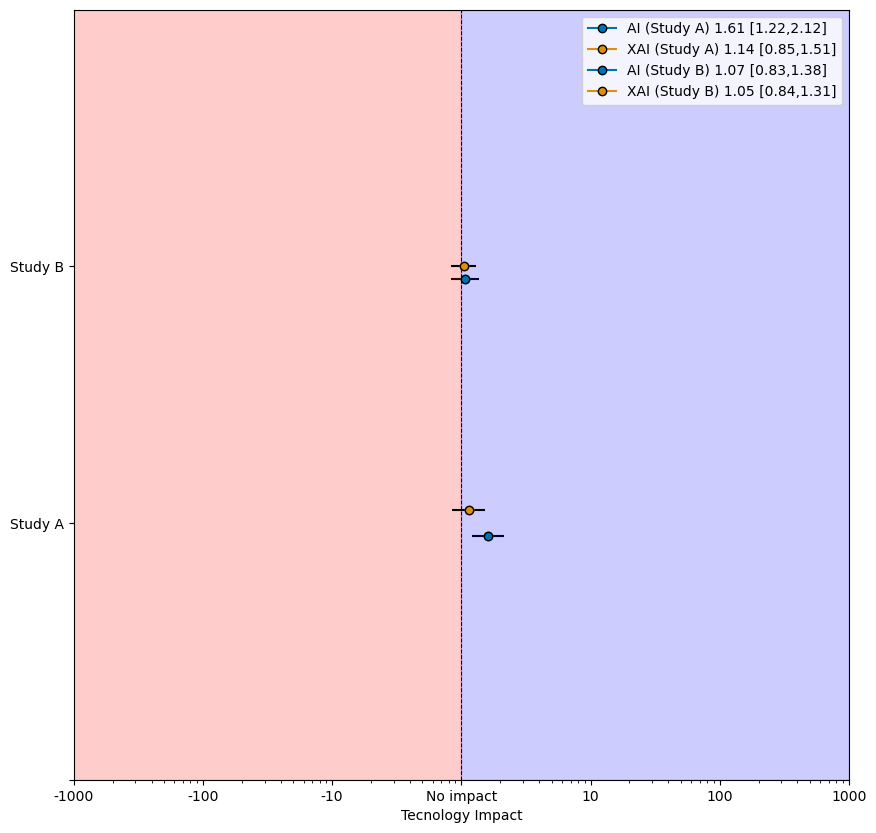

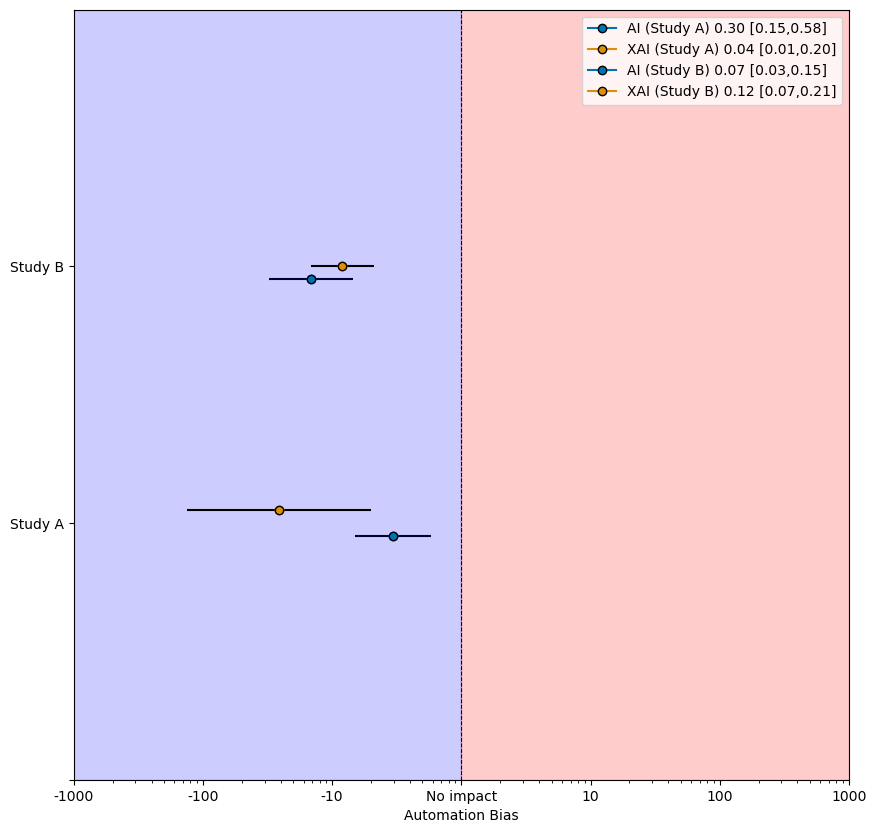

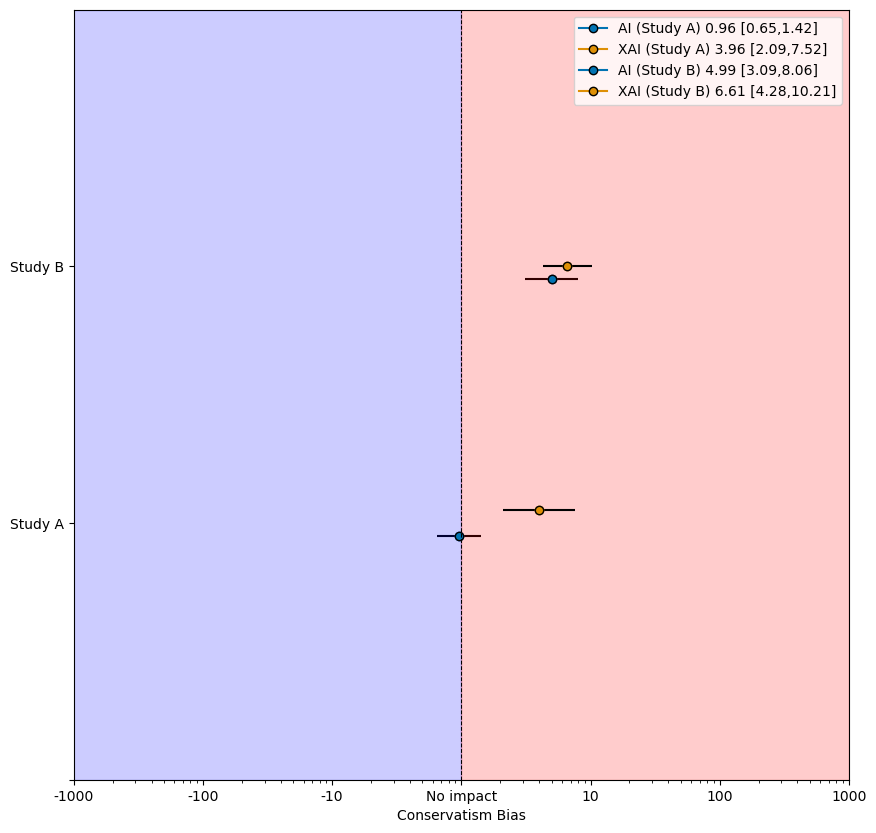

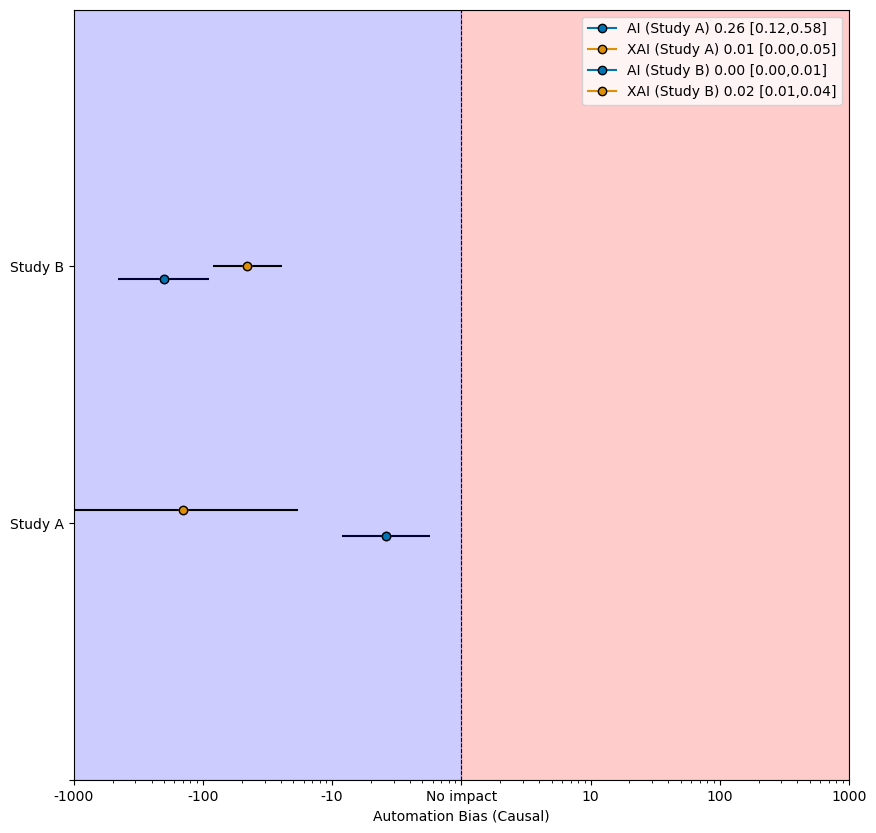

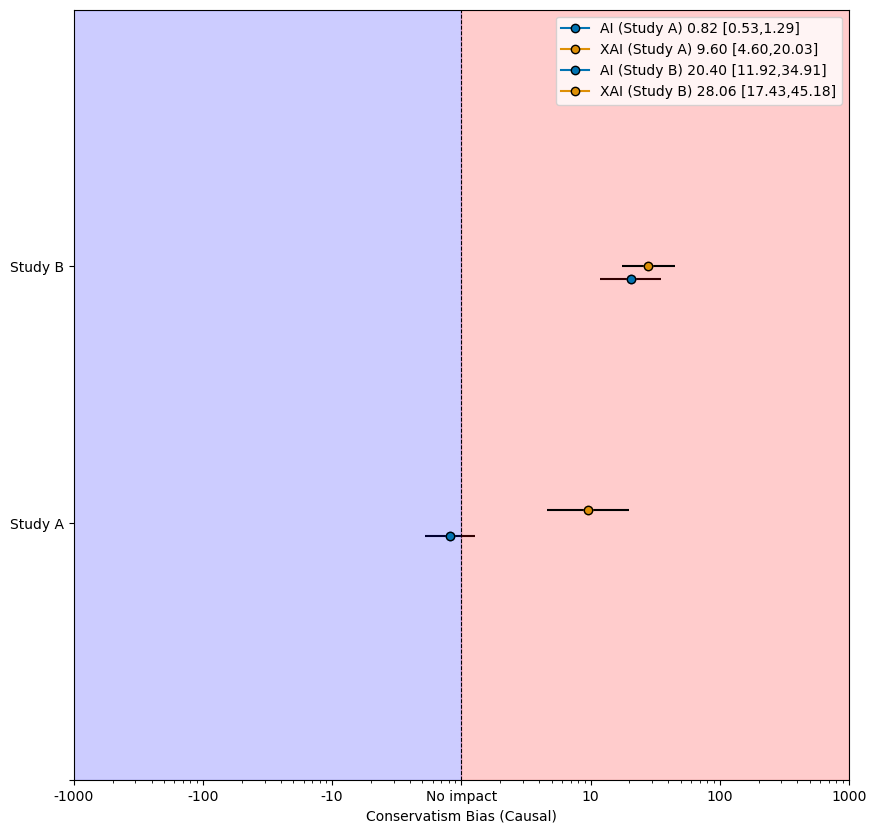

In [5]:
diagrams = compute_chi_diagrams("../data/sample_data.csv")